# Módulos

In [1]:
!pip install spacy>=3.3.0

In [2]:
!python -m spacy download pt_core_news_sm

2022-09-23 13:22:25.079122: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 20.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
!pip install --upgrade gensim>=4.1.2

In [4]:
import os
import base64
import zlib
import gensim
import glob
import nltk
import re
import wordcloud
import string
import itertools
import spacy

nltk.download('punkt')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Parâmetros

In [5]:
ROOTDIR = '/content/drive/MyDrive/Pós/discursos/'
SEED = 12

# Carregar dados

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
if not os.path.isfile(ROOTDIR + 'data/discursos_dataset.json'):

  discursos = pd.DataFrame()

  for arquivo in glob.glob(ROOTDIR + 'data/discursos_*.json'):

    discursos = pd.concat(
              ( discursos, pd.read_json(arquivo) )
    )

  discursos = discursos.reset_index(drop=True)
  discursos['original'] = discursos.discurso_zipped_b64.map(lambda i: zlib.decompress(base64.b64decode(i)).decode())
  discursos = discursos.drop(columns=['discurso_zipped_b64'])

else:
  discursos = pd.read_json(ROOTDIR + 'data/discursos_dataset.json')



In [9]:
# discursos.loc[discursos.idDeputado == 73943].original.iloc[0]

# Preparar os dados para o embedding

## Extraindo as sentenças para criar o embedding

In [10]:
def texto2sentences(texto):

  texto = texto.strip().lower()

  if 'sem revisão do orador.)' in texto.split('\n')[0]:
    texto = texto.split('sem revisão do orador.)')[1].strip()

  if 'pronuncia o seguinte discurso.)' in texto.split('\n')[0]:
    texto = texto.split('pronuncia o seguinte discurso.)')[1].strip()

  if texto.startswith('- sr presidente,'):
    texto = texto.replace('- sr presidente,', '').strip()
  elif ') - ' in texto.split('\n')[0]:
    texto = texto.split(') - ')[1].strip()

  return sent_tokenize(texto)

In [12]:
if not os.path.isfile(ROOTDIR + 'data/discursos_dataset.json'):
  discursos['sentences'] = discursos.original.map(lambda d: texto2sentences(d))

In [13]:
# discursos.loc[discursos.idDeputado == 73943].sentences.iloc[0]

## Tokenizando as sentenças

In [14]:
def limpaSentenca(texto):
  texto = texto.translate(str.maketrans(string.punctuation + '–', ' '*(len(string.punctuation)+1)))
  texto = texto.translate(str.maketrans(string.digits, ' '*len(string.digits)))
  texto = ' '.join(texto.split())
  return texto.strip()

In [15]:
if not os.path.isfile(ROOTDIR + 'data/discursos_dataset.json'):
  discursos['sentences'] = discursos.sentences.map(lambda ss: [word_tokenize(limpaSentenca(s)) for s in ss])

In [16]:
# discursos.loc[discursos.idDeputado == 73943].sentences.iloc[0]

## Discurso inteiro tokenizado

In [17]:
if not os.path.isfile(ROOTDIR + 'data/discursos_dataset.json'):
  discursos['tokens'] = discursos.sentences.map(lambda d: list(itertools.chain.from_iterable(d)))

In [18]:
# discursos.loc[discursos.idDeputado == 73943].tokens.iloc[0]

## Calculando lemmas

In [19]:
nlp = spacy.load('pt_core_news_sm')

In [20]:
if not os.path.isfile(ROOTDIR + 'data/discursos_dataset.json'):
  discursos['lemmas'] = discursos.tokens.map(lambda t: [tk.lemma_ for tk in nlp(' '.join(t))])

In [21]:
# discursos.loc[discursos.idDeputado == 73943].lemmas.iloc[0]

# Preparar e salvar dataset final

In [22]:
if not os.path.isfile(ROOTDIR + 'data/discursos_dataset.json'):
  discursos = discursos.join(pd.read_json(ROOTDIR + 'data/detalhes_deputados.json'), on=['idDeputado'])

In [23]:
# discursos.iloc[0]

In [24]:
if not os.path.isfile(ROOTDIR + 'data/discursos_dataset.json'):
  discursos.to_json(ROOTDIR + 'data/discursos_dataset.json')

## Determinando o tamanho do corpus e frequência das palavras

In [25]:
counter = Counter()
for discurso in discursos.sentences.values:
  for doc in discurso:
    counter.update(doc)

In [26]:
counter_lemmas = Counter()
for doc in discursos.lemmas.values:
  counter_lemmas.update(doc)

### Plota os tokens mais frequentes



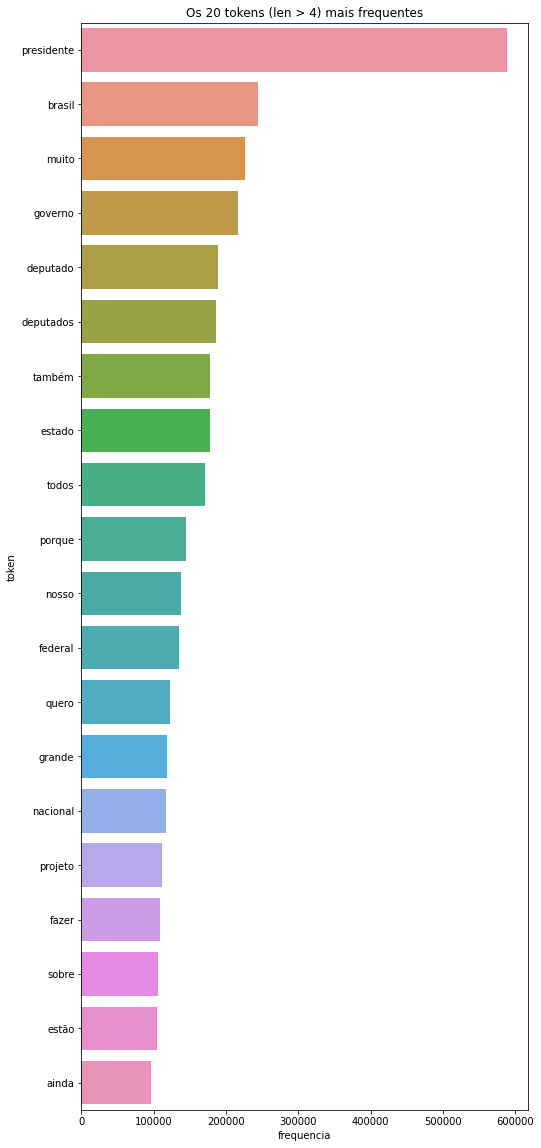

In [27]:
fig, axes = plt.subplots(1,1,figsize=(8,20))
axes.set_title('Os 20 tokens (len > 4) mais frequentes')
sns.barplot(
              ax=axes, x='frequencia', y='token',
              data=pd.DataFrame(
                  [(tk, fr) for tk, fr in counter.most_common(100) if len(tk) > 4][:20], 
                  columns=['token','frequencia']
              ).sort_values(by='frequencia', ascending=False)
);

In [28]:
word_count = len(list(counter))
word_count

198823

In [29]:
lemmas_count = len(list(counter_lemmas))
lemmas_count

178762

# Criando os Word2Vector para os tokens e os lemmas

## Vetor de 50

In [30]:
vector_size = 50

if not os.path.isfile(ROOTDIR + f'data/camares.{vector_size}.w2v'):
  
  minimo_ocorrencias = 5
  window_size = 10
  epocas=20

  model = Word2Vec(vector_size=vector_size, window=window_size, min_count=minimo_ocorrencias, seed=SEED)

  model.build_vocab_from_freq(word_freq=dict(counter.items()))

  doc_count = discursos.shape[0]
    
  pace = 50
  for i in range(0, doc_count, pace):
    if i % 5000 == 0:
      print(i, ' de ', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(np.sum(discursos.iloc[i:i+pace].sentences.values), total_words=len(model.wv.key_to_index), epochs=epocas)

  model.save(ROOTDIR + f'data/camares.{vector_size}.w2v')


if not os.path.isfile(ROOTDIR + f'data/camares.lemmas.{vector_size}.w2v'):
  
  minimo_ocorrencias = 5
  window_size = 10
  epocas=20

  model = Word2Vec(vector_size=vector_size, window=window_size, min_count=minimo_ocorrencias, seed=SEED)

  model.build_vocab_from_freq(word_freq=dict(counter_lemmas.items()))

  doc_count = discursos.shape[0]
    
  pace = 50
  for i in range(0, doc_count, pace):
    if i % 5000 == 0:
      print(i, ' de ', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(np.sum(discursos.iloc[i:i+pace].lemmas.values), total_words=len(model.wv.key_to_index), epochs=epocas)

  model.save(ROOTDIR + f'data/camares.lemmas.{vector_size}.w2v')

## Vetor de 100

In [31]:
vector_size = 100

if not os.path.isfile(ROOTDIR + f'data/camares.{vector_size}.w2v'):

  minimo_ocorrencias = 5
  window_size = 10
  epocas=20

  model = Word2Vec(vector_size=vector_size, window=window_size, min_count=minimo_ocorrencias, seed=SEED)

  model.build_vocab_from_freq(word_freq=dict(counter.items()))

  doc_count = discursos.shape[0]
    
  pace = 50
  for i in range(0, doc_count, pace):
    if i % 5000 == 0:
      print(i, ' de ', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(np.sum(discursos.iloc[i:i+pace].sentences.values), total_words=len(model.wv.key_to_index), epochs=epocas)

  model.save(ROOTDIR + f'data/camares.{vector_size}.w2v')


if not os.path.isfile(ROOTDIR + f'data/camares.lemmas.{vector_size}.w2v'):
  
  minimo_ocorrencias = 5
  window_size = 10
  epocas=20

  model = Word2Vec(vector_size=vector_size, window=window_size, min_count=minimo_ocorrencias, seed=SEED)

  model.build_vocab_from_freq(word_freq=dict(counter_lemmas.items()))

  doc_count = discursos.shape[0]
    
  pace = 50
  for i in range(0, doc_count, pace):
    if i % 5000 == 0:
      print(i, ' de ', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(np.sum(discursos.iloc[i:i+pace].lemmas.values), total_words=len(model.wv.key_to_index), epochs=epocas)

  model.save(ROOTDIR + f'data/camares.lemmas.{vector_size}.w2v')

Output hidden; open in https://colab.research.google.com to view.

## Vetor de 300

In [32]:
vector_size = 300

if not os.path.isfile(ROOTDIR + f'data/camares.{vector_size}.w2v'):

  minimo_ocorrencias = 5
  window_size = 10
  epocas=20

  model = Word2Vec(vector_size=vector_size, window=window_size, min_count=minimo_ocorrencias, seed=SEED)

  model.build_vocab_from_freq(word_freq=dict(counter.items()))

  doc_count = discursos.shape[0]
    
  pace = 50
  for i in range(0, doc_count, pace):
    if i % 5000 == 0:
      print(i, ' de ', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(np.sum(discursos.iloc[i:i+pace].sentences.values), total_words=len(model.wv.key_to_index), epochs=epocas)

  model.save(ROOTDIR + f'data/camares.{vector_size}.w2v')


if not os.path.isfile(ROOTDIR + f'data/camares.lemmas.{vector_size}.w2v'):
  
  minimo_ocorrencias = 5
  window_size = 10
  epocas=20

  model = Word2Vec(vector_size=vector_size, window=window_size, min_count=minimo_ocorrencias, seed=SEED)

  model.build_vocab_from_freq(word_freq=dict(counter_lemmas.items()))

  doc_count = discursos.shape[0]
    
  pace = 50
  for i in range(0, doc_count, pace):
    if i % 5000 == 0:
      print(i, ' de ', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(np.sum(discursos.iloc[i:i+pace].lemmas.values), total_words=len(model.wv.key_to_index), epochs=epocas)

  model.save(ROOTDIR + f'data/camares.lemmas.{vector_size}.w2v')

Output hidden; open in https://colab.research.google.com to view.